## Imports

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizerFast, DistilBertModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm

## Data Exploration

In [9]:
train_set = pd.read_csv('/Users/diogomatias/Desktop/Personal/WikiTaxonomy/src/data/DBPEDIA_train.csv')
val_set = pd.read_csv('/Users/diogomatias/Desktop/Personal/WikiTaxonomy/src/data/DBPEDIA_val.csv')
test_set = pd.read_csv('/Users/diogomatias/Desktop/Personal/WikiTaxonomy/src/data/DBPEDIA_test.csv')

Check dataset split distribution

In [26]:
nrow_train=train_set.shape[0]
nrow_val=val_set.shape[0]
nrow_test=test_set.shape[0]

nrow_dataset=nrow_train+nrow_test+nrow_val

print(f"Train: {round(nrow_train/nrow_dataset*100)}%")
print(f"Validation: {round(nrow_val/nrow_dataset*100)}%")
print(f"Test: {round(nrow_test/nrow_dataset*100)}%")

Train: 71%
Validation: 11%
Test: 18%


Check for class imbalance

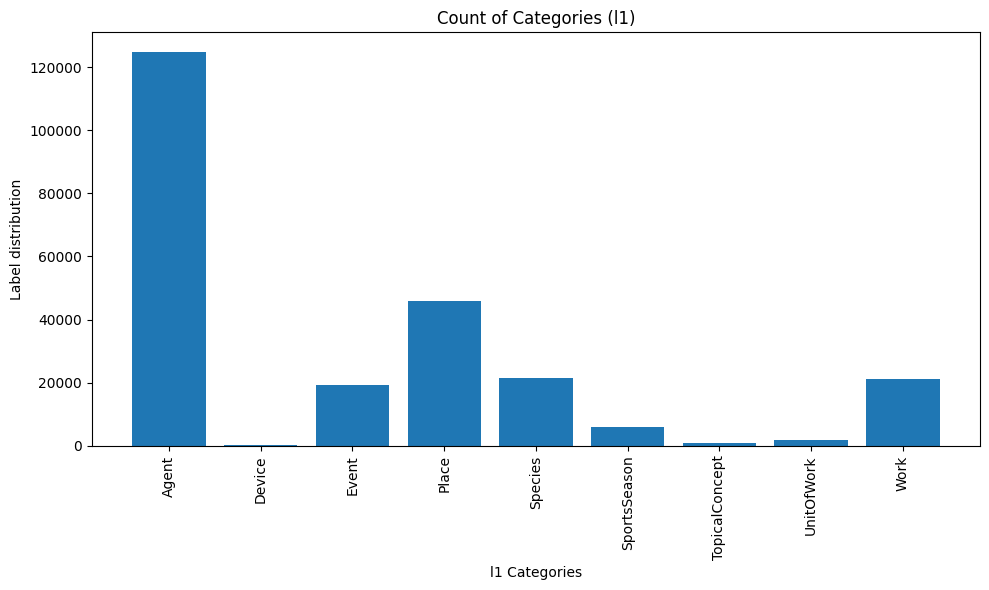

In [44]:
train_class_count = train_set.groupby("l1").count()

# Create a bar plot
plt.figure(figsize=(10, 6))  # Set the figure size
plt.bar(train_class_count.index, train_class_count["text"])
plt.xlabel("l1 Categories")
plt.ylabel("Label distribution")
plt.title("Count of Categories (l1)")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()  # Ensure labels are not cut off
plt.show()

**Conclusion**: In the trainset we face the problem of a clear imbalanced dataset, with the category **Agent** containing the most number of entities. Let's investigate if the same imbalance also occurs in the validation and test set.

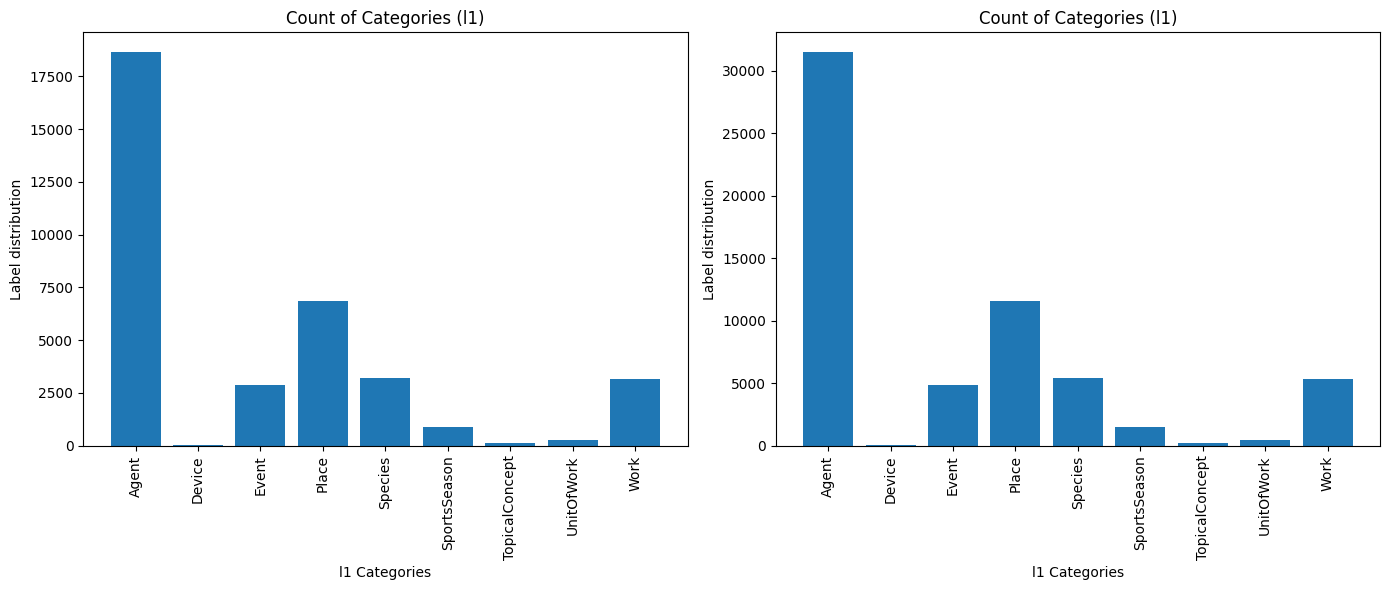

In [45]:
val_class_count = val_set.groupby("l1").count()
test_class_count = test_set.groupby("l1").count()

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6)) 

# Plot the first bar plot on the left subplot
axes[0].bar(val_class_count.index, val_class_count["text"])
axes[0].set_xlabel("l1 Categories")
axes[0].set_ylabel("Label distribution")
axes[0].set_title("Count of Categories (l1)")
axes[0].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for better readability

# Plot the second bar plot on the right subplot (same data)
axes[1].bar(test_class_count.index, test_class_count["text"])
axes[1].set_xlabel("l1 Categories")
axes[1].set_ylabel("Label distribution")
axes[1].set_title("Count of Categories (l1)")
axes[1].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for better readability

# Ensure labels are not cut off
plt.tight_layout()

# Show the plot
plt.show()

**Conclusion**: Same imbalanced distribution of labels is observed both in validation and test set. Being this the case, then we can use the current train, val and test splits as they are, but we will need to tackle class imbalance.

**Check for text length**:

Overall statistics

In [51]:
for dataset_identifier, dataset in [("train_set", train_set), ("valid_set", val_set), ("test_set", test_set)]:
    print(f"Showing statistics for {dataset_identifier}")
    dataset['text_length'] = dataset['text'].apply(len)
    # Calculate overall statistics
    overall_stats = dataset['text_length'].agg(['mean', 'median', 'min', 'max'])
    print(overall_stats)

Showing statistics for train_set
mean       626.702339
median     450.000000
min         50.000000
max       3944.000000
Name: text_length, dtype: float64
Showing statistics for valid_set
mean       624.575535
median     447.000000
min         54.000000
max       3983.000000
Name: text_length, dtype: float64
Showing statistics for test_set
mean       626.797464
median     449.000000
min         52.000000
max       4044.000000
Name: text_length, dtype: float64


Per Label statistics

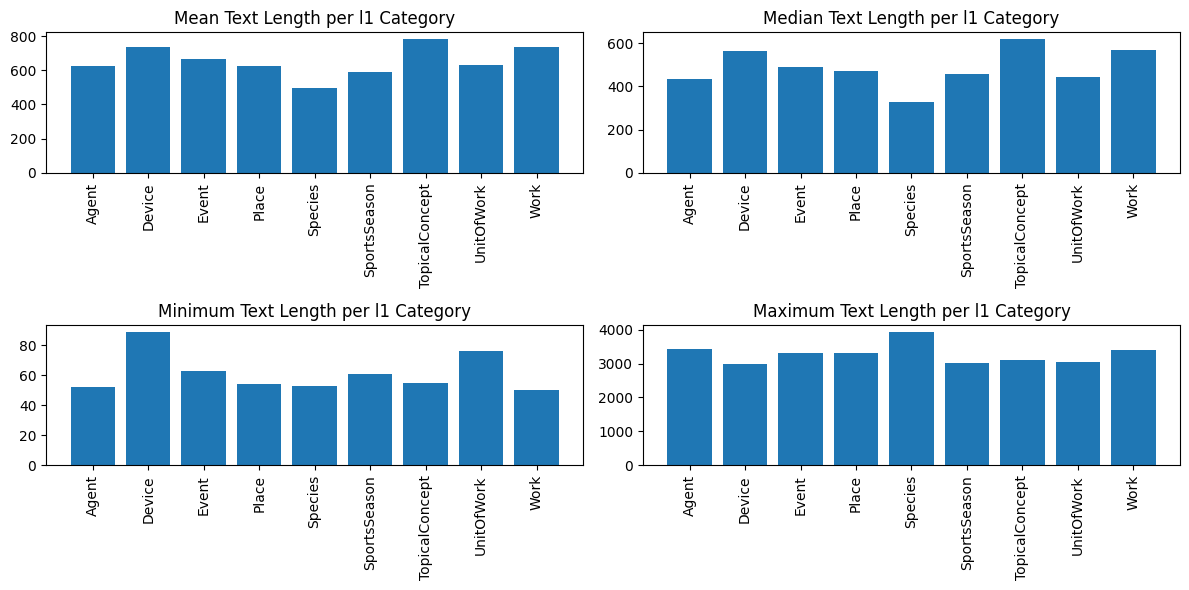

In [49]:
# Calculate text lengths and add a new column to the DataFrame
train_set['text_length'] = train_set['text'].apply(len)

# Group the data by label and calculate statistics
train_label_stats = train_set.groupby('l1')['text_length'].agg(['mean', 'median', 'min', 'max']).reset_index()

# Create a bar plot for each statistic
plt.figure(figsize=(12, 6))

# Mean text length per label
plt.subplot(221)
plt.bar(train_label_stats['l1'], train_label_stats['mean'])
plt.title('Mean Text Length per l1 Category')
plt.xticks(rotation=90)

# Median text length per label
plt.subplot(222)
plt.bar(train_label_stats['l1'], train_label_stats['median'])
plt.title('Median Text Length per l1 Category')
plt.xticks(rotation=90)

# Minimum text length per label
plt.subplot(223)
plt.bar(train_label_stats['l1'], train_label_stats['min'])
plt.title('Minimum Text Length per l1 Category')
plt.xticks(rotation=90)

# Maximum text length per label
plt.subplot(224)
plt.bar(train_label_stats['l1'], train_label_stats['max'])
plt.title('Maximum Text Length per l1 Category')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

**Conclusion**: Taken into consideration that Agent labels is the class with the most entities from it makes sense that the overall statistics approximate to the statistics for this class. This insights will be useful to define the max_length of the model encoder. Usually the language models have a maximum input sequence length, so it's important to ensure that the text data fits within this limit. There may be the need to pad (for smaller text length entities) or to truncate (for larger text length entities).

**Bert Tokenizer -> Investigate the length of the tokens**

In [65]:
BERT_MODEL_NAME = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizerFast.from_pretrained(BERT_MODEL_NAME)

In [66]:
token_counts = []

for index, row in tqdm(train_set.iterrows(), total=len(train_set)):
  token_count = len(tokenizer.encode(
    row["text"], 
    max_length=512, 
    truncation=True
  ))
  token_counts.append(token_count)
     

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 240942/240942 [01:00<00:00, 3973.77it/s]


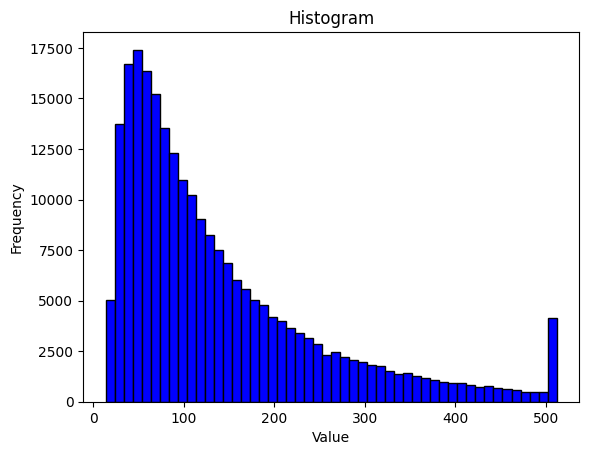

In [71]:
# Create a histogram
plt.hist(token_counts, bins=50, color='blue', edgecolor='black')

# Customize labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')

# Display the histogram
plt.show()

**Observation**: Most of the comments contain less than 300 tokens or more than 512. Hence, I will keep the limit of 512, which is the limit for DistilBertTokenizer. However, there are other models (e.g., Longformer) that can handle larger pieces of text. However, given that the mean text length is 600, I believe that for this exercise, the model should be able to understand the class labels with the 512 token limit